# Construire et entraîner un processus gaussien via l'objet _class_ de python

L'objectif de ce TP est double : 
- apprendre un modèle de processus gaussien à partir de données (régression)
- se familiariser avec l'objet ```class``` de python

Voir https://courspython.com/classes-et-objets.html pour une introduction aux classes.

Version originale : Felipe Tobar, Adapté pour IATI par Elsa Cazelles

#### Le processus gaussien

Dans ce TP, nous considèrerons un noyau de mélange spectral, défini pour deux vecteurs de même taille $x$ et $x'$, et trois paramètres $\gamma, \mu$ et $\sigma$, par:

$$\text{Spec_Mix}(x, x', \gamma, \mu, \sigma) = \sigma^2 * \exp(-\gamma \Vert x-x'\Vert^2)\cos(2\pi\mu\Vert x-x'\Vert).$$

Le modèle de régression considéré est alors le suivant:

$$y \sim \mathcal{GP}(m,K),$$
avec
$$K(x,x') = \text{Spec_Mix}(x, x', \gamma, \mu, \sigma) + \sigma^2_{\text{noise}}\text{Id}.$$

Le vecteur de paramètres est donc donné par

$$\theta = (???).$$

Commençons par importer les modules nécessaires.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


**Exercice :**
Créer un fichier **outils.py**, dans lequel vous définirez le noyau **Spec_Mix($x_1, x_2, \gamma, \mu, \sigma$)**.

Pour cela, utiliser la bibliothèque **numpy**.

**Remarque :** pour le calcul de $\Vert x_1-x_2\Vert$, utiliser la fonction ```np.outer```.

Nous allons maintenant contruire la classe **gp_class**, au fur et à mesure du TP, en y ajoutant des fonctions. En premier lieu, importer la classe en l'appelant dans la variable **gp**.

In [2]:
from gp_class_corrige import *

gp = gp_class()
gp.init_hypers()

Regarder comment se présente la fonction classe dans **gp_class.py**, ainsi que les variables enregistrées dans la classe. Avons-nous des données?

Nous allons construire la fonction ```calcul_posterieur```, qui renvoie la moyenne et la covariance du GP.
- Dans un premier temps, nous n'avons aucune données, la moyenne est considérée nulle, et la covariance du GP est tirée selon une grille pré-définie. Nous pouvons toujours générer plusieurs trajectoires du processus gaussien.
- Dans un second temps, nous avons accès à des données, et la moyenne et la covariance du GP a posteriori dépendront de ces données.


#### Compléter la fonction suivante et l'ajouter à la classe ```gp_class```:

```
def compute_posterior(self, dimension=None, where=None):

        if dimension is None:
            self.N = 100
            self.time = np.linspace(1, 100, 100)
        elif np.size(dimension) == 1:
            self.N = dimension
            self.time = np.linspace(1, 100, dimension)
        if where is not None:
            self.time = where
            self.N = len(where)

        cov_grid = Spec_Mix(self.time, self.time, self.gamma, self.mu, self.sigma) + 1e-5*np.eye(self.N) + self.sigma_n**2*np.eye(self.N)

        if self.x is None:  # no observations
            self.mean = np.zeros_like(self.time)
            self.cov = cov_grid
        else:  # observations
            cov_obs = Spec_Mix(self.x, self.x, self.gamma, self.mu, self.sigma) + 1e-5*np.eye(self.Nx) + self.sigma_n**2*np.eye(self.Nx)
            cov_star = Spec_Mix(self.time, self.x, self.gamma, self.mu, self.sigma)
            self.mean = np.squeeze(
                cov_star@np.linalg.solve(cov_obs, self.y))
            self.cov = cov_grid - (cov_star@np.linalg.solve(cov_obs, cov_star.T))
            
```

**Remarque :** lorsqu'on modifie un object classe, il faut le recharger dans le notebook jupyter. Pour cela, vous avez deux options:

1 :

from importlib import reload

reload(gp_class)


2 :

%load_ext autoreload

%autoreload 2

import gp_class

In [3]:
gp.compute_posterior(dimension=300)

Qu'à fait cette fonction?

Générer ensuite des échantillons via la fonction **sample** dans la classe **gp**.

In [4]:
gp.sample(how_many=5)

array([[ 3.64186217,  0.34371853,  3.13418225, -4.41072324,  7.6428094 ],
       [ 3.83658687,  5.35427484,  1.49065744, -3.22267045,  5.35091309],
       [ 0.82758393,  8.44016692,  1.06557144, -2.96941024,  2.73953104],
       ...,
       [ 3.01173531, 18.38509969, 14.16104103, 25.96557964,  8.4797184 ],
       [ 0.81671384, 16.19413158, 16.45685838, 23.1359574 , 16.45924716],
       [-2.06366316, 13.6288226 , 17.91008266, 19.95381882, 21.53556571]])

Tracer ensuite les trajectoires des ces échantillons, via la fonction plot_samples présente dans la classe **gp**.

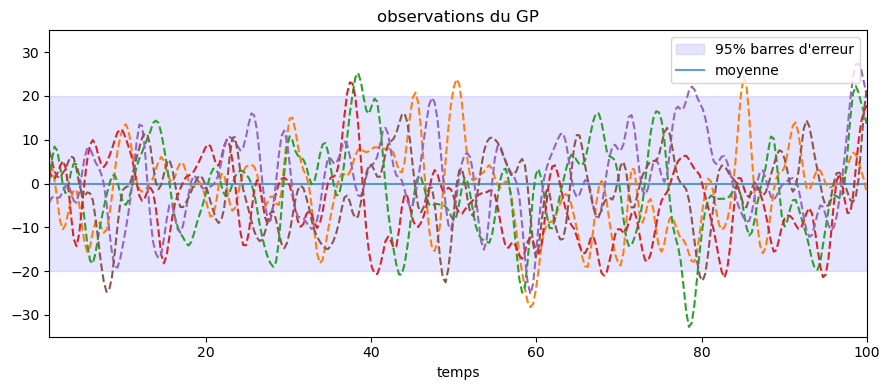

In [5]:
gp.plot_samples()

#### Donnons nous maintenant des observations.

In [6]:
# Produire les données
N = 120
x = 100*np.random.random(N) + 0.1*np.random.randn(N)
y = 20*np.cos(1.5*x)*np.cos(0.1*x) + 0.1*np.random.randn(N)


- Charger les données dans la classe gp.
- Utiliser une fonction de la classe pour afficher les données sur un graphique.

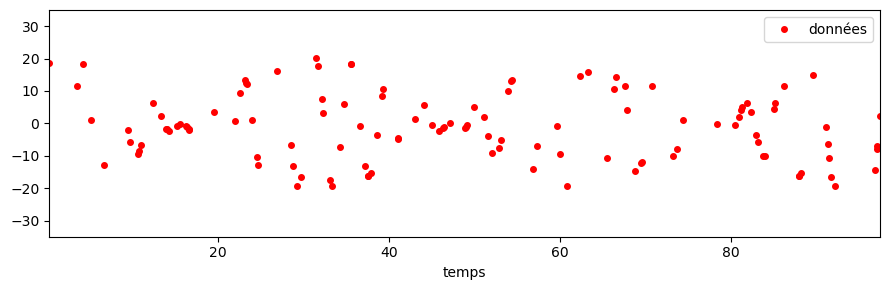

In [7]:
gp.load(x,y)
gp.plot_data()

Calculer de nouveau le GP a posteriori à partir des données $x$ et $y$. Ensuite générer et tracer 5 trajectoires de processus gaussien correspondant à ces données. 

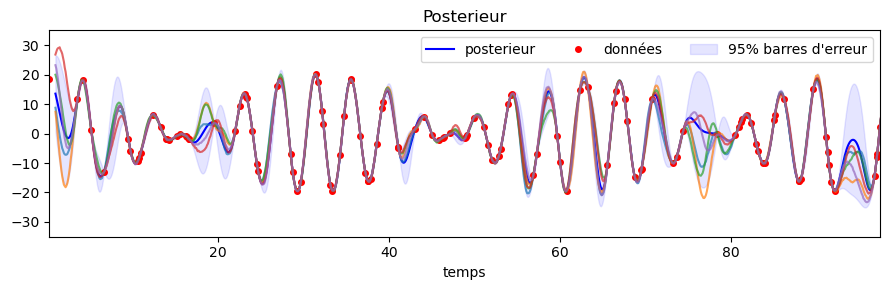

In [8]:
gp.compute_posterior(dimension=1000)
gp.plot_posterior(5,v_axis_lims = 35)

Calculer la log-vraissemblance négative en complétant le code ci-dessous, puis l'inclure dans la classe **gp**.

```
def nll(self):
    Y = self.y
    Gram = Spec_Mix(self.x, self.x, self.gamma,self.mu, self.sigma)
    K = Gram + self.sigma_n**2*np.eye(self.Nx) + 1e-5*np.eye(self.Nx)
    (sign, logdet) = np.linalg.slogdet(K)
    return 0.5*(Y.T@np.linalg.solve(K, Y) + logdet + self.Nx*np.log(2*np.pi))
```

In [9]:
print(f'Log-vraissemblance négative: {gp.nll()}')

Log-vraissemblance négative: 270.9787059630563


## Entraînement des hyper-paramètres du processus gaussien

Pour cela, nous allons utiliser la fonction ```minimize```de ```scipy.optimize```, qui optimisera les hyper-paramètres par descente de gradient. Nous allons donc définir deux fonctions dans la classe gp:
- la fonction de la log-vraisemblance négative ```nlogp```, très proche de ```nll```mais qui prend en entrée les hyperparamètre à optimiser:
```
def nlogp(self, hypers):
    sigma = np.exp(hypers[0])
    gamma = np.exp(hypers[1])
    mu = np.exp(hypers[2])
    sigma_n = np.exp(hypers[3])

    Y = self.y
    Gram = Spec_Mix(self.x, self.x, gamma, mu, sigma)
    K = Gram + sigma_n**2*np.eye(self.Nx) + 1e-5*np.eye(self.Nx)
    (sign, logdet) = np.linalg.slogdet(K)
    return 0.5*(Y.T@np.linalg.solve(K, Y) + logdet + self.Nx*np.log(2*np.pi))
```

- la fonction qui retourne le gradient de ```nlogp``` en fonction des hyperparamètres
```
def dnlogp(self, hypers):
    sigma = np.exp(hypers[0])
    gamma = np.exp(hypers[1])
    mu = np.exp(hypers[2])
    sigma_n = np.exp(hypers[3])

    Y = self.y
    Gram = Spec_Mix(self.x, self.x, gamma, mu, sigma)
    K = Gram + sigma_n**2*np.eye(self.Nx) + 1e-5*np.eye(self.Nx)
    ## h est le résultat de $(K^{-1}Y).T$
    h = np.linalg.solve(K, Y).T

    dKdsigma = 2*Gram/sigma
    dKdgamma = -Gram*(outersum(self.x, -self.x)**2)
    dKdmu = -2*np.pi * Spec_Mix_sine(self.x, self.x, gamma, mu, sigma)*outersum(self.x, -self.x)
    dKdsigma_n = 2*sigma_n*np.eye(self.Nx)

    H = (np.outer(h, h) - np.linalg.inv(K))
    dlogp_dsigma = -sigma * 0.5*np.trace(H@dKdsigma)
    dlogp_dgamma = -gamma * 0.5*np.trace(H@dKdgamma)
    dlogp_dmu = -mu * 0.5*np.trace(H@dKdmu)
    dlogp_dsigma_n = -sigma_n * 0.5*np.trace(H@dKdsigma_n)
    return np.array([dlogp_dsigma, dlogp_dgamma, dlogp_dmu, dlogp_dsigma_n])

```

On peut alors entraîner le modèle via la fonction suivante (à ajouter dans la classe **gp**):

```
def train(self, flag='quiet'):
    hypers0 = np.array([np.log(self.sigma), np.log(self.gamma), np.log(self.mu), np.log(self.sigma_n)])
    res = minimize(self.nlogp, hypers0, args=(), method='L-BFGS-B',
                   jac=self.dnlogp, options={'maxiter': 500, 'disp': True})
    self.sigma = np.exp(res.x[0])
    self.gamma = np.exp(res.x[1])
    self.mu = np.exp(res.x[2])
    self.sigma_n = np.exp(res.x[3])
    self.theta = np.array([self.mu, self.gamma, self.sigma_n])
    if flag != 'quiet':
        print('Hyperparameters are:')
        print(f'sigma ={self.sigma}')
        print(f'gamma ={self.gamma}')
        print(f'mu ={self.mu}')
        print(f'sigma_n ={self.sigma_n}')
```

Effectuer ensuite l'apprentissage des hyperparamètres dans la fonction précédente et afficher la valeur des paramètres après entraînement (via une fonction de la classe **gp**).

In [10]:
gp.train()
gp.show_hypers()

gamma: 0.0008739526021424009, i.e., lengthscale = 23.91889224276492
sigma: 22.411941016596504
sigma_n: 0.10073341182119312
mu: 0.2387396777493668


On peut de nouveau calculer le GP a posteriori et l'évaluer en de nouveaux points.

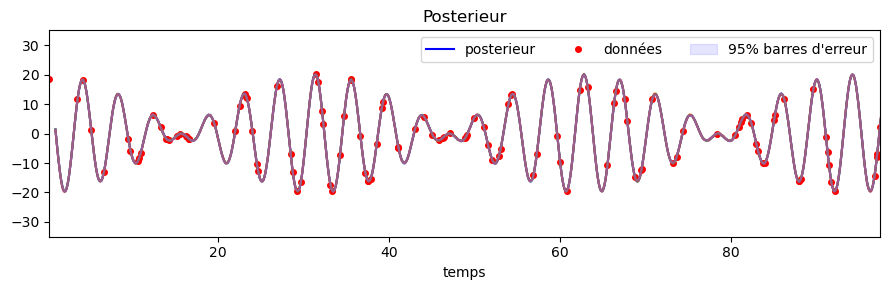

In [11]:
gp.compute_posterior(dimension=1000)
gp.plot_posterior(5)

On remarque alors que la log-vraisemblance négative est minimisée après entraînement:

In [12]:
print(f'negative log-likelihood: {gp.nll()}')

negative log-likelihood: -18.323748126066974


## Exemple sur un jeu de données réelles : fréquence cardiaque

In [13]:
# Chargement et préparation des données

import statsmodels.api as sm

signal = np.loadtxt('hr1.txt') 
time = (np.linspace(0, 1800,1800))
time_label = 'temps'
signal_label = 'Fréquence cardiaque'
        
# On centre le signal
signal = signal - np.mean(signal)

N_obs = 400 # on choisit un nombre de d'observation sur les 1800 disponibles
indices = np.arange(len(signal))
np.random.shuffle(indices)
indices = indices[:N_obs]
indices = np.sort(indices)
signal_init = signal[indices]
time_init = time[indices]


BEFORE TRAINING
negative log-likelihood: 1314.0335764427887
AFTER TRAINING
negative log-likelihood: 988.7689711853357


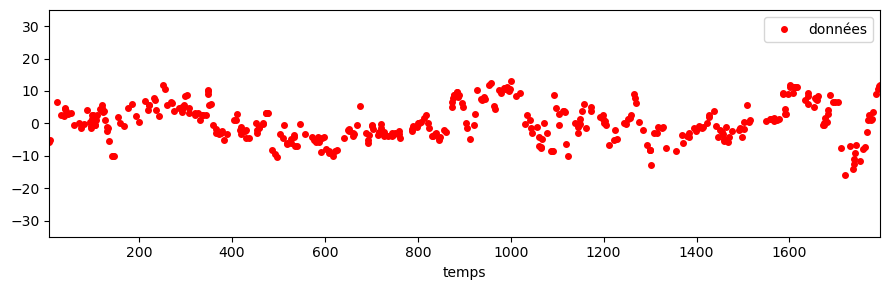

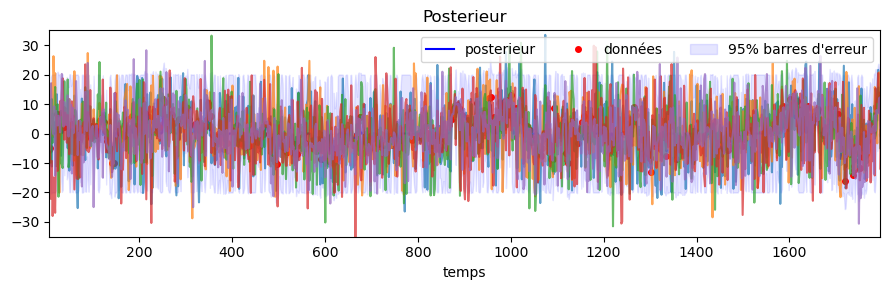

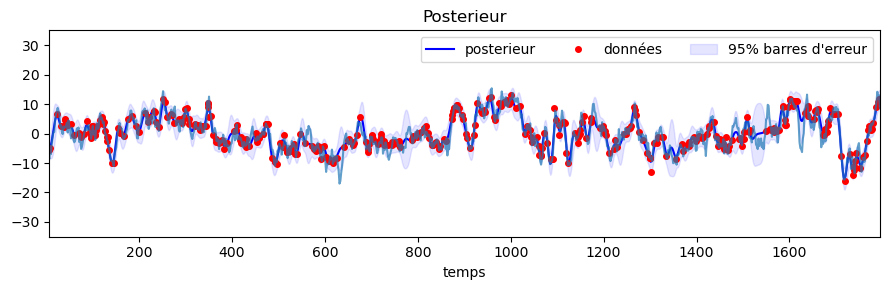

In [14]:
my_gp = gp_class()
my_gp.init_hypers()


my_gp.load(time_init,signal_init)
my_gp.plot_data()

print('BEFORE TRAINING')

my_gp.compute_posterior(where = np.linspace(1,time.max(),1000))
my_gp.plot_posterior(5)
print(f'negative log-likelihood: {my_gp.nll()}')

my_gp.train()


print('AFTER TRAINING')

my_gp.compute_posterior(where = np.linspace(1,np.max(time),1000))
my_gp.plot_posterior(1,v_axis_lims = 55)
print(f'negative log-likelihood: {my_gp.nll()}')

